This chapter covers
---
- Understanding how algorithms can learn from data
-  Reframing learning as parameter estimation, using differentiation and gradient descent
- Walking through a simple learning algorithm
- How PyTorch supports learning with autograd

Data Science Handbook from Kepler (all the way from 1609, pun indeed)
- Got lots of good data from his friend Brahe (not without some struggle)
- Tried to visualize the heck out of it, because he felt there was something fishy going on
- Chose the simplest possible model that had a chance to fit the data (an ellipse)
- Split the data so that he could work on part of it and keep an independent set for validation
- Started with a tentative eccentricity and size for the ellipse and iterated until the model fit the observations
- Validated his model on the independent observations
- Looked back in disbelief


![learning process](../assets/learning%20process.png)

In [1]:
import torch 
from matplotlib import pyplot as plt 
from tqdm import tqdm
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

$$y=w*x+b$$

In [2]:
class Net(torch.nn.Module):
    def __init__(self,input_size,output_size) -> None:
        super(Net,self).__init__()
        
        self.linear = torch.nn.Linear(in_features=input_size,out_features=output_size,bias=True)

        with torch.no_grad():
            self.linear.weight.fill_(1)
            self.linear.bias.fill_(0)
    
    def forward(self,x):
        return self.linear(x)

In [3]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0,-4.0, 6.0, 13.0, 21.0],device=device)
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],device=device)

c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


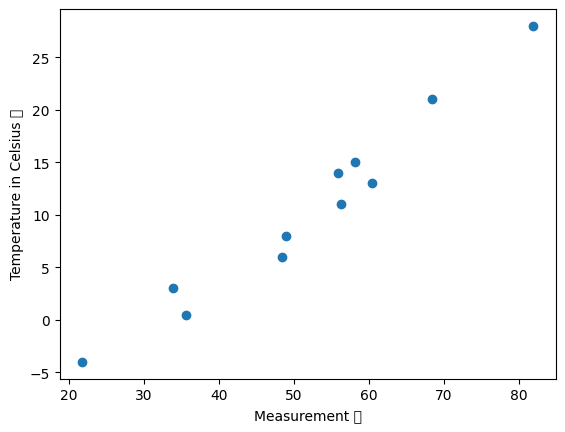

In [4]:
plt.scatter(t_u.detach().cpu().numpy(),t_c.detach().cpu().numpy())
plt.xlabel("Measurement 📐") #Unknown units
plt.ylabel("Temperature in Celsius 🥵")
plt.show()

Solution:: $t_c = w*t_u + b$, where $w$ is weights and  $b$ is bias.

 A loss function (or cost function) is a function that computes a single numerical value that the learning process will attempt to minimize. 
 
 The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples.

In [5]:
simpleNet = Net(1,1).to(device=device)

In [6]:
print("model initial parameters::") 
for i in simpleNet.named_parameters(): print(i)

model initial parameters::
('linear.weight', Parameter containing:
tensor([[1.]], device='cuda:0', requires_grad=True))
('linear.bias', Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True))


In [7]:
from torchinfo import summary
summary(model=simpleNet,input_size=(1,),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Optimizers

These optimization tricks that can assist convergence, especially when models get complicated

- Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically with requires_grad set to **True**) as the first input
- All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their *grad* attribute.
- Each optimizer exposes two methods: *zero_grad* and *step*
    - as name follows *zero_grad* zeroes the *grad* attribute
    - *step* updates the values of those parameters according to optim strategy


![Optimizers Works](../assets/Optimizers.png)


- (A) Conceptual representation of how an optimizer holds a reference to  parameters. 
- (B) After a *loss* is computed from inputs
- (C) a call to *.backward* leads to  *.grad* being populated on parameters. 
- (D) At that point, the optimizer can access *.grad* and compute the parameter updates.


In [8]:
# Training
optimizer = torch.optim.Adam(simpleNet.parameters(), lr=1e-3)

epoch:int = 6500
training_losses = []
for i in tqdm(range(0,epoch)):
    training_loss = 0
    for inputs,outputs in zip(t_u,t_c):
        inputs = torch.tensor([inputs],device=device)
        outputs = torch.tensor([outputs],device=device)
        optimizer.zero_grad()
        pred = simpleNet(inputs)
        loss = torch.nn.functional.mse_loss(outputs,pred)
        training_loss+=loss 
        loss.backward()
        optimizer.step()
    if i%1000==0: training_losses.append(training_loss)

100%|██████████| 6500/6500 [01:10<00:00, 92.60it/s] 


In [9]:
print("model trained parameters::")
for i in simpleNet.named_parameters(): print(i) 

model trained parameters::
('linear.weight', Parameter containing:
tensor([[0.5017]], device='cuda:0', requires_grad=True))
('linear.bias', Parameter containing:
tensor([-15.3174], device='cuda:0', requires_grad=True))


c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\muthu\miniconda3\envs\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129397 (\N{OVERHEATED FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


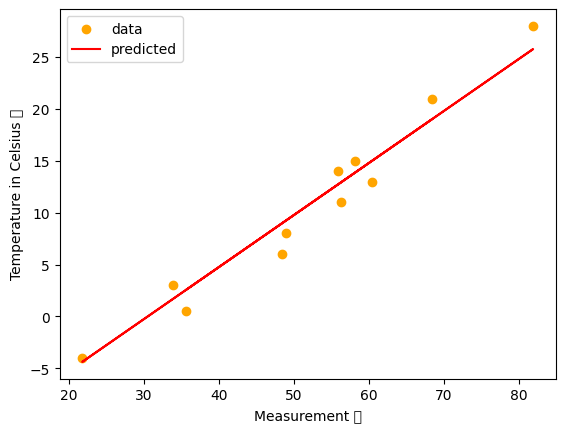

In [10]:
res = t_u*simpleNet.linear.weight + simpleNet.linear.bias 
plt.scatter(t_u.detach().cpu().numpy(),t_c.detach().cpu().numpy(),c='orange',label='data')
plt.plot(t_u.detach().cpu().numpy(),res.flatten().detach().cpu().numpy(),c='r',label="predicted")
plt.xlabel("Measurement 📐") #Unknown units
plt.ylabel("Temperature in Celsius 🥵")
plt.legend()
plt.show()

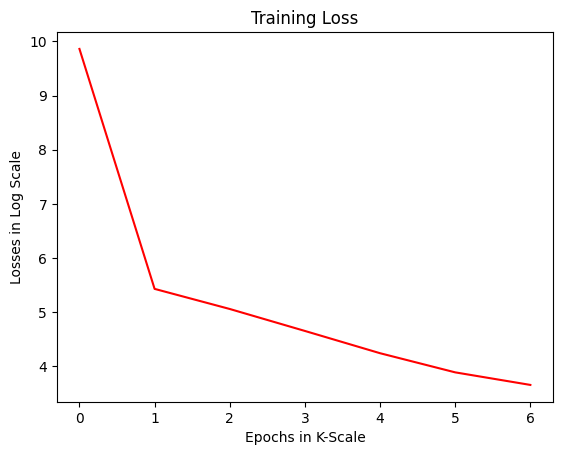

In [11]:
plt.plot(torch.log(torch.tensor([_.detach().cpu().item() for _ in training_losses])).detach().cpu(),c='r')
plt.xlabel("Epochs in K-Scale")
plt.ylabel("Losses in Log Scale")
plt.title("Training Loss")
plt.show()

$$ax^2+bx+c$$

In [12]:
class QuadraticEq(torch.nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()
        self.a  = torch.nn.Parameter( torch.ones(1) ,requires_grad=True)
        self.b  = torch.nn.Parameter( torch.ones(1) ,requires_grad=True)
        self.c  = torch.nn.Parameter( torch.ones(1) ,requires_grad=True)

        with torch.no_grad():
            self.a.fill_(1)
            self.b.fill_(1)
            self.c.fill_(1)

    def forward(self,x):
        return ( (self.a * x**2) + (self.b * x) + self.c )
    
eq = QuadraticEq(1,1).to('cuda')

summary(model=eq,input_size=(1,),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
QuadraticEq                              [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [13]:
print("model initialized with {}, {} and {}".format(eq.a,eq.b,eq.c))

model initialized with Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True) and Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


In [14]:
# Training
optimizer = torch.optim.Adam(eq.parameters(), lr=1e-2)

epoch:int = 400
training_losses = []
for i in tqdm(range(0,epoch)):
    training_loss = 0
    for inputs,outputs in zip(t_u,t_c):
        inputs = torch.tensor([inputs],device=device)
        outputs = torch.tensor([outputs],device=device)
        optimizer.zero_grad()
        pred = eq(inputs)
        loss = torch.nn.functional.mse_loss(outputs,pred)
        training_loss+=loss 
        loss.backward()
        optimizer.step()
    training_losses.append(training_loss)

100%|██████████| 400/400 [00:04<00:00, 82.91it/s]


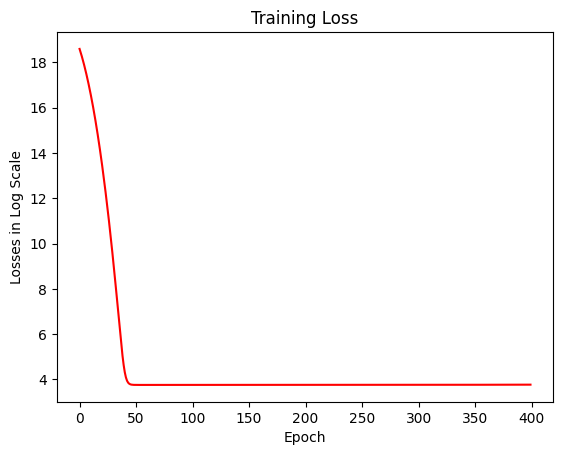

In [15]:
plt.plot(torch.log(torch.tensor([_.detach().cpu().item() for _ in training_losses])).detach().cpu(),c='r')
plt.ylabel("Losses in Log Scale")
plt.xlabel("Epoch")
plt.title("Training Loss")
plt.show()

C:\Users\muthu\AppData\Local\Temp\ipykernel_4992\3778052356.py:6: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(get_eq(torch.range(0,torch.max(t_u),device=device)).detach().cpu().numpy(),c='green',label='smooth line' )


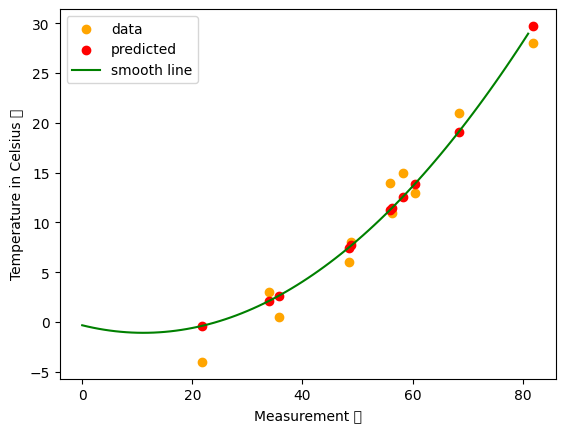

In [16]:
results = eq.a*t_u**2+ eq.b*t_u + eq.c
get_eq = lambda x: eq.a*x**2 + eq.b*x + eq.c

plt.scatter(t_u.detach().cpu().numpy(),t_c.detach().cpu().numpy(),c='orange',label='data')
plt.scatter(t_u.detach().cpu().numpy(), results.detach().cpu().numpy() ,c='r',label="predicted")
plt.plot(get_eq(torch.range(0,torch.max(t_u),device=device)).detach().cpu().numpy(),c='green',label='smooth line' )
plt.xlabel("Measurement 📐") #Unknown units
plt.ylabel("Temperature in Celsius 🥵")
plt.legend()
plt.show()